In [2]:
#Load necessary packages
import pandas as pd
import os
import numpy as np
import copy
import pickle
import random

import matplotlib.pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

from numpy.polynomial.polynomial import polyfit

### Data Prep - all code condensed from previous Notebooks

In [3]:
##CODE FROM NOTEBOOK: Library_Week2_Notebook4_Strategy#2
#(Load and process data created in Library_Week2_Notebook4_Strategy#2)

#Load data
os.chdir("//Users/Olga/Documents/INSIGHT2019/Library data/AllPldData")
Files_in_folder = os.listdir()
File_names = ['_2014', '_2015', '_2016', '_2001', '_2002', '_2003', 
              '_2004','_2005', '_2006', '_2007', '_2008', '_2009', 
              '_2010', '_2011', '_2012', '_2013', '_2000', '_1992', 
              '_1993', '_1994', '_1995', '_1996', '_1997', '_1998', '_1999']
Files = []

for filename in os.listdir():
    if filename.endswith('csv'):
        Files.append(pd.read_csv(filename, encoding = 'latin-1', low_memory = False))
        
#create dictionary of libraries labeled by year
LibData_dict = {}
for i in range(0, len(File_names)):
    LibData_dict[File_names[i]] = Files[i]
    
for k, v in LibData_dict.items():
    print(k, v.shape, type(LibData_dict[k]))

ColumnsPresent = pd.DataFrame(index=range(0),columns=range(0))

for k, v in LibData_dict.items():
    dataframe_to_join = pd.DataFrame({k: list(v.columns)})
    ColumnsPresent = ColumnsPresent.join(dataframe_to_join, how = 'outer')

#Rearrange columns in dataframe. 
cols = ColumnsPresent.columns.tolist()
cols_rearr = cols[17:] + cols[0:17]
cols_rearr2 = cols_rearr[0:8] + cols_rearr[24:25] + cols_rearr[11:24] + cols_rearr[8:11]

ColumnsPresent_rearr = ColumnsPresent[cols_rearr2]

ColumnsPresent_rearr_str = ColumnsPresent_rearr.applymap(str)
ColumnsPresent_rearr_str = ColumnsPresent_rearr_str.reset_index(drop = True)

#create DF of unique column values
UniqueLabels = np.unique(ColumnsPresent_rearr_str.values)
LabelsBoolDF = pd.DataFrame(UniqueLabels)

#Create DF w boolean values for prensence of each unique value
#THIS IS THE END GOAL OF THIS DATA
for j in range(len(ColumnsPresent_rearr_str.columns)):
    lis = []
    for i in range(len(UniqueLabels)):
        lis.append(ColumnsPresent_rearr_str.iloc[:, j].isin([UniqueLabels[i]]).any())
    LabelsBoolDF[ColumnsPresent_rearr_str.columns[j]] = lis
    
## Sum all TRUE values. Value of 25 = all true
sum_list = []
for i in range(LabelsBoolDF.shape[0]):
    sum_list.append(sum(LabelsBoolDF.iloc[i, 1:26]))

#Label OK in Notes
LabelsBoolDF['TRUE SUM'] = sum_list
LabelsBoolDF['Notes'] = ""
LabelsBoolDF.loc[LabelsBoolDF[LabelsBoolDF['TRUE SUM']==25].index, 'Notes'] = "OK"

#rows in which not all TRUE (meaning this column/data does not exist for all year)
MissingData = LabelsBoolDF[LabelsBoolDF['TRUE SUM']!=25].index.tolist()

#Column names to keep
#LabelsBoolDF.loc[[0, 3:13, 15], 0].tolist()
Cols_to_keep_idx = [0]
Cols_to_keep_idx.extend(range(3,13))
Cols_to_keep_idx.extend((16, 18, 20, 25, 26))
Cols_to_keep_idx.extend(range(33, 49))
Cols_to_keep_idx.extend((64, 135, 137, 138, 183))
Cols_to_keep_idx.extend(range(185, 189))
Cols_to_keep_idx.extend(range(191, 199))
Cols_to_keep_idx.append(201)
Cols_to_keep_idx.extend(range(206, 219))
Cols_to_keep_idx.append(220)
Cols_to_keep_idx.extend(range(222, 229))
Cols_to_keep_idx.extend((230, 231, 237))
Cols_to_keep_idx.extend(range(237, 256))
Cols_to_keep_idx.extend(range(257, 260))
Cols_to_keep_idx.extend((262, 263))

Cols_to_keep_in_lib_dfs = LabelsBoolDF.iloc[Cols_to_keep_idx, 0].tolist()

#Make dictionaries of smaller dataframe with Cols_to_keep_in_lib_dfs ONLY
LibData_dict_reduced = dict()

for k, v in LibData_dict.items():
    LibData_dict_reduced[k] = pd.DataFrame()
    for i in Cols_to_keep_in_lib_dfs:
        if i in v:
            TempList = list(v[i])
            LibData_dict_reduced[k][i] = TempList

#Did above loop do what I thought it did?
print("Original dfs:")
for k, v in LibData_dict.items():
    print(k, v.shape)

print("\n", "Reduced dfs:")  
for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)

#Combine col names that mean same thing in different years into single 
Names_to_combine = ["ATTEND", "VISITS",  "C_LEGBAS", "C_LEGBASE", "DUPLI", "HRS_OPEN", "KIDATTEN", "KIDATTEND", 
                    "LIBRARIAN", "LIBRARIA", "POPU", "POPU_LSA", "POPU_UND", "POPU_UNDUP", "REFERENC", "REFERENCE", 
                    "STAFFEXP", "TOTEXP", "SUBSCRIP", "SUBSCRIPT", "TOTEXPCO", "TOTEXPCOL", 
                    "TOTOPEXP", "TOTOPEXP1", "TOTPEMP", "TOTSTAFF", "ZIP", "ZIP1"]

for i in range(0, len(Names_to_combine)-1, 2):
    for k, v in LibData_dict_reduced.items(): 
        if Names_to_combine[i] in v:
            name = Names_to_combine[i]
            newname = Names_to_combine[i] + "-" + Names_to_combine[i+1]
            v = v.rename(columns = {name: newname}, inplace = True)
        elif Names_to_combine[i+1] in v:
            name = Names_to_combine[i + 1]
            newname = Names_to_combine[i] + "-" + Names_to_combine[i+1]
            v = v.rename(columns = {name : newname}, inplace = True)

#Check that above code worked - names changes
for k, v in LibData_dict_reduced.items():
    print(v.columns)

for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)

#Columns to add to DFs
"AUDIO is divided into AUDIO_PH, AUDIO_DL starting 2010. Source: 2010 Documentation."
"VIDEO was later split into VIDEO_DL and VIDEO_PH."

for k, v in LibData_dict_reduced.items(): 
    if "AUDIO_DL" in v:
        v["AUDIO"] = v['AUDIO_DL'] + v['AUDIO_PH']
    if "VIDEO_DL" in v:
        v["VIDEO"] = v['VIDEO_DL'] + v['VIDEO_PH']

#Check that # columns in some dataframes increased by 2 (expected)
for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)
    
#Create DF w boolean values for prensence of each unique value in REDUCED dataframes
#THIS IS THE END GOAL OF THIS DATA

#Get all unique columns present in LibData_dict_reduced dataframes. 
ColumnsPresent_reduced = pd.DataFrame(index=range(0),columns=range(0))

for k, v in LibData_dict_reduced.items():
    dataframe_to_join_reduced = pd.DataFrame({k: list(v.columns)})
    ColumnsPresent_reduced = ColumnsPresent_reduced.join(dataframe_to_join_reduced, how = 'outer')

ColumnsPresent_reduced_str = ColumnsPresent_reduced.applymap(str)
ColumnsPresent_reduced_str = ColumnsPresent_reduced_str.reset_index(drop = True)
    
UniqueLabels_reduced = np.unique(ColumnsPresent_reduced_str.values)
LabelsBoolDF_reduced = pd.DataFrame(UniqueLabels_reduced)

#Create DF w boolean values for prensence of each unique value
#THIS IS THE END GOAL OF THIS DATA
for j in range(len(ColumnsPresent_reduced_str.columns)):
    lis = []
    for i in range(len(UniqueLabels_reduced)):
        lis.append(ColumnsPresent_reduced_str.iloc[:, j].isin([UniqueLabels_reduced[i]]).any())
    LabelsBoolDF_reduced[ColumnsPresent_reduced_str.columns[j]] = lis

## Sum all TRUE values. Value of 25 = all true
sum_list_reduced = []
for i in range(LabelsBoolDF_reduced.shape[0]):
    sum_list_reduced.append(sum(LabelsBoolDF_reduced.iloc[i, 1:26]))

#Label OK in Notes
LabelsBoolDF_reduced['TRUE SUM'] = sum_list_reduced
LabelsBoolDF_reduced['Notes'] = ""
LabelsBoolDF_reduced.loc[LabelsBoolDF_reduced[LabelsBoolDF_reduced['TRUE SUM']==25].index, 'Notes'] = "OK"

All_Cols_in_Reduced_dfs = list(LabelsBoolDF_reduced[0])
All_Cols_in_Reduced_dfs

for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)
    
#Delete columns deemed NOT useful for downstream analysis
NonUsefulColstoDelete = ['ENDDATE', 'LIBID', 'PHONE', 'POPU_UND-POPU_UNDUP', 'RSTATUS', 'TOTCOLL', 'ZIP-ZIP1']

LibData_dict_reduced_dropuseless = copy.deepcopy(LibData_dict_reduced)

for k, v in LibData_dict_reduced_dropuseless.items(): 
    for i in range(len(NonUsefulColstoDelete)):
        if NonUsefulColstoDelete[i] in v:
            v.drop([NonUsefulColstoDelete[i]], axis = 1, inplace = True)
            
#Check quickly whether columns were dropped
print("Reduced dfs:")
for k, v in LibData_dict_reduced.items():    
    print(k, v.shape)

print("\n", "Reduced and dropped useless dfs:")
for k, v in LibData_dict_reduced_dropuseless.items():    
    print(k, v.shape)

#Get rid of negative values (replace w NaN)
#For all DFs, replace (-1, -3, -9) values with NaN. 
LibData_dict_reduced_dropuseless_NegRepWNaN = copy.deepcopy(LibData_dict_reduced_dropuseless)

for k, v in LibData_dict_reduced_dropuseless_NegRepWNaN.items():
    v[(v == -1) | (v == -3) | (v == -9)] = np.nan
    
#See if this worked (looks like it did)
print(sum(LibData_dict_reduced_dropuseless['_2014']['AUDIO_DL'] < 0))
print(np.where((LibData_dict_reduced_dropuseless['_2014']['AUDIO_DL'] < 0) == True))

print(sum(LibData_dict_reduced_dropuseless_NegRepWNaN['_2014']['AUDIO_DL'].isnull()))
print(np.where(LibData_dict_reduced_dropuseless_NegRepWNaN['_2014']['AUDIO_DL'].isnull()))

for k, v in LibData_dict_reduced_dropuseless_NegRepWNaN.items():
    print(k, v.shape)
    


_2014 (9305, 159) <class 'pandas.core.frame.DataFrame'>
_2015 (9251, 159) <class 'pandas.core.frame.DataFrame'>
_2016 (9252, 151) <class 'pandas.core.frame.DataFrame'>
_2001 (9133, 108) <class 'pandas.core.frame.DataFrame'>
_2002 (9141, 107) <class 'pandas.core.frame.DataFrame'>
_2003 (9214, 110) <class 'pandas.core.frame.DataFrame'>
_2004 (9210, 128) <class 'pandas.core.frame.DataFrame'>
_2005 (9201, 131) <class 'pandas.core.frame.DataFrame'>
_2006 (9211, 139) <class 'pandas.core.frame.DataFrame'>
_2007 (9217, 148) <class 'pandas.core.frame.DataFrame'>
_2008 (9284, 150) <class 'pandas.core.frame.DataFrame'>
_2009 (9299, 152) <class 'pandas.core.frame.DataFrame'>
_2010 (9308, 154) <class 'pandas.core.frame.DataFrame'>
_2011 (9315, 157) <class 'pandas.core.frame.DataFrame'>
_2012 (9305, 155) <class 'pandas.core.frame.DataFrame'>
_2013 (9309, 157) <class 'pandas.core.frame.DataFrame'>
_2000 (9078, 108) <class 'pandas.core.frame.DataFrame'>
_1992 (8944, 83) <class 'pandas.core.frame.DataF

_1999 (9048, 52)
_2014 (9305, 69)
_2015 (9251, 72)
_2016 (9252, 77)
_2001 (9133, 52)
_2002 (9141, 52)
_2003 (9214, 53)
_2004 (9210, 56)
_2005 (9201, 60)
_2006 (9211, 61)
_2007 (9217, 61)
_2008 (9284, 62)
_2009 (9299, 64)
_2010 (9308, 67)
_2011 (9315, 67)
_2012 (9305, 67)
_2013 (9309, 68)
_2000 (9078, 52)
_1992 (8944, 44)
_1993 (8929, 44)
_1994 (8920, 44)
_1995 (8981, 49)
_1996 (8946, 49)
_1997 (8968, 49)
_1998 (8966, 51)
_1999 (9048, 52)
Reduced dfs:
_2014 (9305, 69)
_2015 (9251, 72)
_2016 (9252, 77)
_2001 (9133, 52)
_2002 (9141, 52)
_2003 (9214, 53)
_2004 (9210, 56)
_2005 (9201, 60)
_2006 (9211, 61)
_2007 (9217, 61)
_2008 (9284, 62)
_2009 (9299, 64)
_2010 (9308, 67)
_2011 (9315, 67)
_2012 (9305, 67)
_2013 (9309, 68)
_2000 (9078, 52)
_1992 (8944, 44)
_1993 (8929, 44)
_1994 (8920, 44)
_1995 (8981, 49)
_1996 (8946, 49)
_1997 (8968, 49)
_1998 (8966, 51)
_1999 (9048, 52)

 Reduced and dropped useless dfs:
_2014 (9305, 63)
_2015 (9251, 66)
_2016 (9252, 70)
_2001 (9133, 47)
_2002 (9141, 47)


In [5]:
##CODE FROM NOTEBOOK: Library_Week2_Notebook4_Strategy#2
#(Load and process data created in Library_Week2_Notebook4_Strategy#2)

#Add usage column to each library
for k, v in LibData_dict_reduced_dropuseless_NegRepWNaN.items():
    v['Usage'] = v['ATTEND-VISITS']/v['POPU-POPU_LSA']
    
#Check that column was added
for k, v in LibData_dict_reduced_dropuseless_NegRepWNaN.items():
    print(k, v.shape)
    
#Remove all rows (libraries) for which Usage data missing for any window!
LibwUsage = copy.deepcopy(LibData_dict_reduced_dropuseless_NegRepWNaN)
for k, v in LibwUsage.items():
    NullInd = v[v.Usage.isnull()].index
    print(k, v.shape)
    v = v.drop(NullInd, axis = 0)
    print(k, v.shape)

_2014 (9305, 64)
_2015 (9251, 67)
_2016 (9252, 71)
_2001 (9133, 48)
_2002 (9141, 48)
_2003 (9214, 49)
_2004 (9210, 51)
_2005 (9201, 55)
_2006 (9211, 56)
_2007 (9217, 56)
_2008 (9284, 57)
_2009 (9299, 59)
_2010 (9308, 62)
_2011 (9315, 62)
_2012 (9305, 62)
_2013 (9309, 63)
_2000 (9078, 48)
_1992 (8944, 40)
_1993 (8929, 40)
_1994 (8920, 40)
_1995 (8981, 45)
_1996 (8946, 45)
_1997 (8968, 45)
_1998 (8966, 47)
_1999 (9048, 48)
_2014 (9305, 64)
_2014 (9259, 64)
_2015 (9251, 67)
_2015 (9231, 67)
_2016 (9252, 71)
_2016 (9234, 71)
_2001 (9133, 48)
_2001 (9131, 48)
_2002 (9141, 48)
_2002 (9138, 48)
_2003 (9214, 49)
_2003 (9214, 49)
_2004 (9210, 51)
_2004 (9207, 51)
_2005 (9201, 55)
_2005 (9198, 55)
_2006 (9211, 56)
_2006 (9208, 56)
_2007 (9217, 56)
_2007 (9214, 56)
_2008 (9284, 57)
_2008 (9257, 57)
_2009 (9299, 59)
_2009 (9256, 59)
_2010 (9308, 62)
_2010 (9273, 62)
_2011 (9315, 62)
_2011 (9275, 62)
_2012 (9305, 62)
_2012 (9265, 62)
_2013 (9309, 63)
_2013 (9263, 63)
_2000 (9078, 48)
_2000 (9078, 4

In [6]:
##CODE FROM NOTEBOOK: Library_Week2_Notebook4_Strategy#2
#(Load and process data created in Library_Week2_Notebook4_Strategy#2)

#Create DF w boolean values for prensence of each unique value in REDUCED dataframes
#THIS IS THE END GOAL OF THIS DATA

#Get all unique columns present in LibData_dict_reduced dataframes. 
ColumnsPresent_reduced = pd.DataFrame(index=range(0),columns=range(0))

for k, v in LibwUsage .items():
    dataframe_to_join_reduced = pd.DataFrame({k: list(v.columns)})
    ColumnsPresent_reduced = ColumnsPresent_reduced.join(dataframe_to_join_reduced, how = 'outer')
    
UniqueLabels_reduced = np.unique(ColumnsPresent_reduced_str.values)
LabelsBoolDF_reduced = pd.DataFrame(UniqueLabels_reduced)

#Create DF w boolean values for prensence of each unique value
#THIS IS THE END GOAL OF THIS DATA
for j in range(len(ColumnsPresent_reduced_str.columns)):
    lis = []
    for i in range(len(UniqueLabels_reduced)):
        lis.append(ColumnsPresent_reduced_str.iloc[:, j].isin([UniqueLabels_reduced[i]]).any())
    LabelsBoolDF_reduced[ColumnsPresent_reduced_str.columns[j]] = lis
    
#Reorder columns
colnames = LabelsBoolDF_reduced.columns.tolist()
col_order = colnames[0:1] + colnames[18:26] + colnames[17:18] + colnames[4:17] + colnames[1:4]
LabelsBoolDF_reduced = LabelsBoolDF_reduced[col_order]

## Sum all TRUE values. Value of 25 = all true
sum_list_reduced_all = []
for i in range(LabelsBoolDF_reduced.shape[0]):
    sum_list_reduced_all.append(sum(LabelsBoolDF_reduced.iloc[i, 1:26]))
    
sum_list_reduced_ten = []
for i in range(LabelsBoolDF_reduced.shape[0]):
    sum_list_reduced_ten.append(sum(LabelsBoolDF_reduced.iloc[i, 15:26]))
    
sum_list_reduced_six = []
for i in range(LabelsBoolDF_reduced.shape[0]):
    sum_list_reduced_six.append(sum(LabelsBoolDF_reduced.iloc[i, 19:26]))

#Label OK in Notes
LabelsBoolDF_reduced['All_Years_Present'] = sum_list_reduced_all
LabelsBoolDF_reduced['2006_2016_Present'] = sum_list_reduced_ten
LabelsBoolDF_reduced['2010_2016_Present'] = sum_list_reduced_six

#Based on this, I will use 2010-2016 DF. This has the most values.
LabelsBoolDF_reduced.loc[29: ,:]

#Rename first column
LabelsBoolDF_reduced.rename(columns = {LabelsBoolDF_reduced.columns[0] : "Col"}, inplace = True)

In [7]:
##CODE FROM NOTEBOOK: Library_Week2_Notebook4_Strategy#2
#(Load and process data created in Library_Week2_Notebook4_Strategy#2)

#Make sure each df has all 83 columns. If column did not exist, add this column with NaN
Unique_col_names_list = list(LabelsBoolDF_reduced['Col'])

LibwUsage_2 = copy.deepcopy(LibwUsage)

for k, v in LibwUsage_2.items():
    for i in range(len(Unique_col_names_list)):
        if Unique_col_names_list[i] not in v:
            v[Unique_col_names_list[i]] = np.nan

for k, v in LibwUsage_2.items():
    print(k, v.shape)

_2014 (9305, 85)
_2015 (9251, 85)
_2016 (9252, 85)
_2001 (9133, 85)
_2002 (9141, 85)
_2003 (9214, 85)
_2004 (9210, 85)
_2005 (9201, 85)
_2006 (9211, 85)
_2007 (9217, 85)
_2008 (9284, 85)
_2009 (9299, 85)
_2010 (9308, 85)
_2011 (9315, 85)
_2012 (9305, 85)
_2013 (9309, 85)
_2000 (9078, 85)
_1992 (8944, 85)
_1993 (8929, 85)
_1994 (8920, 85)
_1995 (8981, 85)
_1996 (8946, 85)
_1997 (8968, 85)
_1998 (8966, 85)
_1999 (9048, 85)


## Concatenate DFs, delete some non-useful columns

In [9]:
#Concatenate 2010-2016
Concat201116 = pd.concat([LibwUsage_2['_2010'], LibwUsage_2['_2011'], LibwUsage_2['_2012'], LibwUsage_2['_2013'], LibwUsage_2['_2014'], LibwUsage_2['_2015'], LibwUsage_2['_2016']], axis=0, sort = False, join = "outer")
print(Concat201116.shape)

#rename first col
LabelsBoolDF_reduced.rename(columns = {LabelsBoolDF_reduced.columns[0] : "Col"}, inplace = True)

#Which features are not present in all 7 years?
Index = LabelsBoolDF_reduced[LabelsBoolDF_reduced['2010_2016_Present'] != 7].index

#Delete these features from DF.
Cols_to_delete = LabelsBoolDF_reduced.loc[Index, 'Col']
Cols_to_del_list = list(Cols_to_delete[:-1])
print("Columns to delete:", Cols_to_del_list)
Concat201116_INCOMPLETECOLSDEL = Concat201116.drop(columns = Cols_to_del_list)

print(Concat201116.shape)
print(Concat201116_INCOMPLETECOLSDEL.shape)

#Nonuseful columns to delete from above:
NonUsefulColstoDelete = ['ENDDATE', 'LIBID', 'PHONE', 'POPU_UND-POPU_UNDUP', 'RSTATUS', 'ZIP-ZIP1', 'nan']
Concat201116_INCOMPLETECOLSDEL2 = Concat201116_INCOMPLETECOLSDEL.drop(columns = NonUsefulColstoDelete)
print(Concat201116_INCOMPLETECOLSDEL2.shape)

Concat201116_INCOMPLETECOLSDEL2.columns

#I SHOULD CHECK THIS MORE CAREFULLY ON FRI!!

#Columns to move to front, not use 
'ADDRESS', 'ATTEND-VISITS', 'CITY', 'CNTY', 'FSCSKEY', 'LIBNAME',   

#Columns to delete prior to analysis
'AUDIO_DL', 'AUDIO_PH'

#Columns to categorize -- DELETE FOR NOW, but for tomorrow may was to categorize
'GEOCODE', 'LOCALE', 'OBEREG', 'STABR', 'C_LEGBAS-C_LEGBASE'

#Delete 'AUDIO_DL', 'AUDIO_PH'
Concat201116_INCOMPLETECOLSDEL3 = Concat201116_INCOMPLETECOLSDEL2.drop(columns = ['AUDIO_DL', 'AUDIO_PH'])
#Put 'ADDRESS', 'ATTEND-VISITS', 'CITY', 'CNTY', 'FSCSKEY', 'LIBNAME' in dif DF
Location_Detail_DF = Concat201116_INCOMPLETECOLSDEL2[['ADDRESS', 'ATTEND-VISITS', 'CITY', 'CNTY', 'FSCSKEY', 'LIBNAME']]

#NOW delete from concatDF
Concat201116_INCOMPLETECOLSDEL4 = Concat201116_INCOMPLETECOLSDEL3.drop(columns = ['ADDRESS', 'ATTEND-VISITS', 'CITY', 'CNTY', 'FSCSKEY', 'LIBNAME'])

#Do NOT make location columns into dummy variables. We will delete these anyways.
#Concat_w_dummies = pd.get_dummies(Concat201116_INCOMPLETECOLSDEL4, columns=['GEOCODE', 'LOCALE', 'OBEREG', 'STABR', 'C_LEGBAS-C_LEGBASE'], prefix=['GEOCODE', 'LOCALE', 'OBEREG', 'STABR', 'C_LEGBAS-C_LEGBASE'])

print(Concat201116_INCOMPLETECOLSDEL2.shape, Concat201116_INCOMPLETECOLSDEL3.shape, Concat201116_INCOMPLETECOLSDEL4.shape)

#NOW HAVE 2 DFs:
#Concat201116_INCOMPLETECOLSDEL4
#Location_Detail_DF


(65045, 85)
Columns to delete: ['EC_LO_OT', 'EC_ST', 'ELACCEXP', 'ELCONT', 'ELECCOLL', 'ELINFO', 'ELMATCIR', 'ELMATS', 'ELSVCACC', 'ERES_USR', 'ESUBSCRP', 'INETACC', 'PHYSCIR', 'REAPLOCALE', 'TOTCOLL', 'WIFISESS']
(65045, 85)
(65045, 69)
(65045, 62)
(65045, 62) (65045, 60) (65045, 54)


## Prep for dataframe to run in RF

In [10]:
## REMOVE ALL USAGE FEATURES (EXCEPT WHAT I AM TRYING TO PREDICT). 
#GET RID OF VIDEO_DL, VIDEO_PH for now too
ReducedDF = Concat201116_INCOMPLETECOLSDEL4.drop(columns = ['GPTERMS', 'KIDATTEN-KIDATTEND', 'KIDCIRCL', 'PITUSR', 'REGBOR', 'SUBSCRIP-SUBSCRIPT', 'TOTATTEN', 'TOTCIR', 'YAATTEN', 'REFERENC-REFERENCE', 'GEOCODE', 'LOCALE', 'OBEREG', 'STABR', 'C_LEGBAS-C_LEGBASE', 'VIDEO_DL', 'VIDEO_PH'])

#Leave 'Usage', 'POPU-POPU_LSA', so that I can divide!!

In [11]:
ReducedDF.columns

Index(['BENEFIT', 'BKMOB', 'BKVOL', 'BRANLIB', 'CAPITAL', 'CAP_REV', 'CENTLIB',
       'EBOOK', 'ELMATEXP', 'FCAP_REV', 'DUPLI-HRS_OPEN', 'KIDPRO',
       'LIBRARIAN-LIBRARIA', 'LOANFM', 'LOANTO', 'LOCGVT', 'MASTER',
       'OCAP_REV', 'OTHINCM', 'OTHMATEX', 'OTHOPEXP', 'OTHPAID',
       'POPU-POPU_LSA', 'PRMATEXP', 'SALARIES', 'SCAP_REV', 'STAFFEXP-TOTEXP',
       'STGVT', 'TOTEXPCO-TOTEXPCOL', 'TOTINCM', 'TOTOPEXP-TOTOPEXP1',
       'TOTPRO', 'TOTPEMP-TOTSTAFF', 'YAPRO', 'AUDIO', 'VIDEO', 'Usage'],
      dtype='object')

In [12]:
#Now, get rid of NaN, spaces
#First, NaN
print(ReducedDF.shape)
print(Location_Detail_DF.shape)

ReducedDF = ReducedDF.reset_index(drop = True)
Location_Detail_DF = Location_Detail_DF.reset_index(drop = True)

#Get null rows
print(len(pd.isnull(ReducedDF).any(1).nonzero()[0]))
idx = pd.isnull(ReducedDF).any(1).nonzero()[0]

#Delete_row_w_any_NaN
ReducedDF_noNaN = ReducedDF.drop(idx)
Location_Detail_DF_noNaN = Location_Detail_DF.drop(idx)

print(ReducedDF_noNaN.shape, Location_Detail_DF_noNaN.shape)

#Second, spaces
#4 columns - 'OTHOPEXP', 'SALARIES', 'STAFFEXP-TOTEXP', 'BENEFIT' - are objects, meaning some balues are non-numeric
#It looks like some are left blank.
print(ReducedDF_noNaN[ReducedDF_noNaN.OTHOPEXP == ' '].index)
print(ReducedDF_noNaN[ReducedDF_noNaN.SALARIES == ' '].index)
print(ReducedDF_noNaN[ReducedDF_noNaN['STAFFEXP-TOTEXP'] == ' '].index)
print(ReducedDF_noNaN[ReducedDF_noNaN.BENEFIT == ' '].index)

#Are all indices the same? YES. 
print(len(ReducedDF_noNaN[ReducedDF_noNaN.OTHOPEXP == ' '].index.intersection(ReducedDF_noNaN[ReducedDF_noNaN.SALARIES == ' '].index)))
print(len(ReducedDF_noNaN[ReducedDF_noNaN.OTHOPEXP == ' '].index.intersection(ReducedDF_noNaN[ReducedDF_noNaN['STAFFEXP-TOTEXP'] == ' '].index)))
print(len(ReducedDF_noNaN[ReducedDF_noNaN.OTHOPEXP == ' '].index.intersection(ReducedDF_noNaN[ReducedDF_noNaN.BENEFIT == ' '].index)))

IndexToDropSpaces = ReducedDF_noNaN[ReducedDF_noNaN.OTHOPEXP == ' '].index

ReducedDF_noNaN_noSpace = ReducedDF_noNaN.drop(IndexToDropSpaces)
Location_Detail_DF_noNaN_noSpace = Location_Detail_DF_noNaN.drop(IndexToDropSpaces)
print(ReducedDF_noNaN.shape, Location_Detail_DF_noNaN.shape)
print(ReducedDF_noNaN_noSpace.shape, Location_Detail_DF_noNaN_noSpace.shape)

(65045, 37)
(65045, 6)
21142
(43903, 37) (43903, 6)
Int64Index([37237, 37239, 37242, 37243, 37244, 37245, 37247, 37248, 37250,
            37251,
            ...
            46487, 46488, 46490, 46499, 46501, 46502, 46503, 46510, 46516,
            46517],
           dtype='int64', length=3309)
Int64Index([37237, 37239, 37242, 37243, 37244, 37245, 37247, 37248, 37250,
            37251,
            ...
            46487, 46488, 46490, 46499, 46501, 46502, 46503, 46510, 46516,
            46517],
           dtype='int64', length=3309)
Int64Index([37237, 37239, 37242, 37243, 37244, 37245, 37247, 37248, 37250,
            37251,
            ...
            46487, 46488, 46490, 46499, 46501, 46502, 46503, 46510, 46516,
            46517],
           dtype='int64', length=3309)
Int64Index([37237, 37239, 37242, 37243, 37244, 37245, 37247, 37248, 37250,
            37251,
            ...
            46487, 46488, 46490, 46499, 46501, 46502, 46503, 46510, 46516,
            46517],
           

In [13]:
### Remove Outliers, defined as anything over mean+5*SD

ReducedDF_noNaN_noSpace = ReducedDF_noNaN_noSpace.reset_index(drop = True)
Location_Detail_DF_noNaN_noSpace = Location_Detail_DF_noNaN_noSpace.reset_index(drop = True)

mean_plus_5xSD = ReducedDF_noNaN_noSpace.Usage.mean() + 5*ReducedDF_noNaN_noSpace.Usage.std()
OutlierIdx = ReducedDF_noNaN_noSpace[ReducedDF_noNaN_noSpace.Usage > mean_plus_5xSD].index
print("Number of outliers:", ReducedDF_noNaN_noSpace.loc[OutlierIdx, ['Usage']].shape[0])
      
ReducedDF_noNaN_noSpace_DropOutliers=ReducedDF_noNaN_noSpace.drop(OutlierIdx)
Location_Detail_DF_noNaN_noSpace_DropOutliers=Location_Detail_DF_noNaN_noSpace.drop(OutlierIdx)

print(ReducedDF_noNaN_noSpace.shape, ReducedDF_noNaN_noSpace_DropOutliers.shape)
print(Location_Detail_DF_noNaN_noSpace.shape, Location_Detail_DF_noNaN_noSpace_DropOutliers.shape)

#NOW the two DFs to work with is:
#ReducedDF_noNaN_noSpace_DropOutliers
#Location_Detail_DF_noNaN_noSpace_DropOutliers

Number of outliers: 56
(40594, 37) (40538, 37)
(40594, 6) (40538, 6)


## Prep Dataframe to run in RF 2: Divide columns that make sense by population served

In [14]:
#divide everything by population
ReducedDF_noNaN_noSpace_DropOutliers_POPDIV = copy.deepcopy(ReducedDF_noNaN_noSpace_DropOutliers)

cols_to_divide_by_pop = ['BENEFIT','BKMOB','BKVOL','BRANLIB','CAPITAL','CAP_REV','CENTLIB','EBOOK','ELMATEXP',
 'FCAP_REV','KIDPRO','LIBRARIAN-LIBRARIA','LOANFM','LOANTO','LOCGVT','MASTER',
 'OCAP_REV','OTHINCM','OTHMATEX','OTHOPEXP','OTHPAID',
 'PRMATEXP','SALARIES','SCAP_REV','STAFFEXP-TOTEXP','STGVT','TOTEXPCO-TOTEXPCOL',
 'TOTINCM','TOTOPEXP-TOTOPEXP1','TOTPRO','TOTPEMP-TOTSTAFF','YAPRO','AUDIO','VIDEO']


for col in cols_to_divide_by_pop:
    ReducedDF_noNaN_noSpace_DropOutliers_POPDIV[col] = ReducedDF_noNaN_noSpace_DropOutliers_POPDIV[col].astype(float)
    ReducedDF_noNaN_noSpace_DropOutliers_POPDIV[col] = ReducedDF_noNaN_noSpace_DropOutliers_POPDIV[col].astype(float)/ReducedDF_noNaN_noSpace_DropOutliers_POPDIV['POPU-POPU_LSA']

## Get random 20% of libs to remove

In [ ]:
###GET random set of libraries to remove
Location_Detail_DF_noNaN_noSpace_DropOutliers = Location_Detail_DF_noNaN_noSpace_DropOutliers.reset_index(drop=True)
ReducedDF_noNaN_noSpace_DropOutliers_POPDIV = ReducedDF_noNaN_noSpace_DropOutliers_POPDIV.reset_index(drop=True)

UniqueFSCS = set(Location_Detail_DF_noNaN_noSpace_DropOutliers.loc[:, 'FSCSKEY'].tolist())
print(len(UniqueFSCS))

#Pick 20% of FSCSKEYS randomly
Numb_to_sel = int((.20*len(UniqueFSCS)))
_20PctFSCSList = random.sample(UniqueFSCS, Numb_to_sel)

#Get index of these FSCSKEYS from Location_Detail_DF_noNaN_noSpace
Indexlist = list()
for FSCSkey in _20PctFSCSList:
    Indexfor_20PctFSCSList = Location_Detail_DF_noNaN_noSpace_DropOutliers[Location_Detail_DF_noNaN_noSpace_DropOutliers.FSCSKEY == FSCSkey].index
    Indexlist.append(list(Indexfor_20PctFSCSList))
flattened_Indexlist = [val for sublist in Indexlist for val in sublist]
print(len(flattened_Indexlist))

In [ ]:
#RF with SPECIFIC libraries removed.
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 60)

X = ReducedDF_noNaN_noSpace_DropOutliers_POPDIV.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = ReducedDF_noNaN_noSpace_DropOutliers_POPDIV['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

## What if I run with different random sample?

In [ ]:
#Define function that picks random 20% of libraries
def Pick20PCTLIBS(Location_Detail_DF_noNaN_noSpace_DropOutliers, ReducedDF_noNaN_noSpace_DropOutliers_POPDIV):
    ###GET random set of libraries to remove
    Location_Detail_DF_noNaN_noSpace_DropOutliers = Location_Detail_DF_noNaN_noSpace_DropOutliers.reset_index(drop=True)
    ReducedDF_noNaN_noSpace_DropOutliers_POPDIV = ReducedDF_noNaN_noSpace_DropOutliers_POPDIV.reset_index(drop=True)

    UniqueFSCS = set(Location_Detail_DF_noNaN_noSpace_DropOutliers.loc[:, 'FSCSKEY'].tolist())

    #Pick 20% of FSCSKEYS randomly
    Numb_to_sel = int((.20*len(UniqueFSCS)))
    _20PctFSCSList = random.sample(UniqueFSCS, Numb_to_sel)

    #Get index of these FSCSKEYS from Location_Detail_DF_noNaN_noSpace
    Indexlist = list()
    for FSCSkey in _20PctFSCSList:
        Indexfor_20PctFSCSList = Location_Detail_DF_noNaN_noSpace_DropOutliers[Location_Detail_DF_noNaN_noSpace_DropOutliers.FSCSKEY == FSCSkey].index
        Indexlist.append(list(Indexfor_20PctFSCSList))
    flattened_Indexlist = [val for sublist in Indexlist for val in sublist]
    return flattened_Indexlist

In [ ]:
a = Pick20PCTLIBS(Location_Detail_DF_noNaN_noSpace_DropOutliers, ReducedDF_noNaN_noSpace_DropOutliers_POPDIV)
b = Pick20PCTLIBS(Location_Detail_DF_noNaN_noSpace_DropOutliers, ReducedDF_noNaN_noSpace_DropOutliers_POPDIV)

In [ ]:
#Define RF function
#RF with SPECIFIC libraries removed.
def RandomForestModel1(ReducedDF_noNaN_noSpace_DropOutliers_POPDIV, flattened_Indexlist):
    rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 60)

    X = ReducedDF_noNaN_noSpace_DropOutliers_POPDIV.drop(columns = ['Usage', 'POPU-POPU_LSA'])
    y = ReducedDF_noNaN_noSpace_DropOutliers_POPDIV['Usage']

    X_train = X.drop(X.index[flattened_Indexlist])
    y_train = y.drop(y.index[flattened_Indexlist])
    X_test = X.loc[flattened_Indexlist]
    y_test = y.loc[flattened_Indexlist]

    #Train model on TRAIN set
    rfmodel.fit(X_train, y_train);

    #Test model on TEST set (this is the right this to do)
    predictions = rfmodel.predict(X_test)
    errors = abs(predictions - y_test)
    #df of predictions, labels and errors
    df_TEST = pd.DataFrame()
    df_TEST['Usage_val'] = y_test
    df_TEST['Predictions'] = predictions
    df_TEST['errors'] = (list(errors))

    #Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
    predictions = rfmodel.predict(X_train)
    errors = abs(predictions - y_train)
    #df of predictions, labels and errors
    df_TRAIN = pd.DataFrame()
    df_TRAIN['Usage_val'] = y_train
    df_TRAIN['Predictions'] = predictions
    df_TRAIN['errors'] = (list(errors))

    #Get feature importance
    feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                       index = X_train.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

    #Plot df_TEST Usage vs. Prediction:
    # Data
    x = df_TEST.iloc[:, 0]
    y = df_TEST.iloc[:, 1]
    # Fit with polyfit
    b, m = polyfit(x, y, 1)
    plt.plot(x, y, '.')
    plt.plot(x, b + m * x, '-')
    plt.show()

    #Plot df_TRAIN Usage vs. Prediction:
    # Data
    x = df_TRAIN.iloc[:, 0]
    y = df_TRAIN.iloc[:, 1]
    # Fit with polyfit
    b, m = polyfit(x, y, 1)
    plt.plot(x, y, '.')
    plt.plot(x, b + m * x, '-')
    plt.show()

    print("Score for Test set: ", rfmodel.score(X_test, y_test))
    print("Score for Train set: ", rfmodel.score(X_train, y_train))


In [ ]:
#Run random forest with 2 different sets of libs removed from training set
RandomForestModel1(ReducedDF_noNaN_noSpace_DropOutliers_POPDIV, a)
RandomForestModel1(ReducedDF_noNaN_noSpace_DropOutliers_POPDIV, b)

In [ ]:
## Good news is that feature importance is pretty consistent. 

## What if I run with different random state?

In [ ]:
#Not the most efficient way to do it, but will define new model to allow change in random state
#At some point, I should combine these models
def RandomForestModel2(ReducedDF_noNaN_noSpace_DropOutliers_POPDIV, flattened_Indexlist, number):
    rfmodel = RandomForestRegressor(n_estimators = 100, random_state = number, max_depth = 60)

    X = ReducedDF_noNaN_noSpace_DropOutliers_POPDIV.drop(columns = ['Usage', 'POPU-POPU_LSA'])
    y = ReducedDF_noNaN_noSpace_DropOutliers_POPDIV['Usage']

    X_train = X.drop(X.index[flattened_Indexlist])
    y_train = y.drop(y.index[flattened_Indexlist])
    X_test = X.loc[flattened_Indexlist]
    y_test = y.loc[flattened_Indexlist]

    #Train model on TRAIN set
    rfmodel.fit(X_train, y_train);

    #Test model on TEST set (this is the right this to do)
    predictions = rfmodel.predict(X_test)
    errors = abs(predictions - y_test)
    #df of predictions, labels and errors
    df_TEST = pd.DataFrame()
    df_TEST['Usage_val'] = y_test
    df_TEST['Predictions'] = predictions
    df_TEST['errors'] = (list(errors))

    #Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
    predictions = rfmodel.predict(X_train)
    errors = abs(predictions - y_train)
    #df of predictions, labels and errors
    df_TRAIN = pd.DataFrame()
    df_TRAIN['Usage_val'] = y_train
    df_TRAIN['Predictions'] = predictions
    df_TRAIN['errors'] = (list(errors))

    #Get feature importance
    feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                       index = X_train.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

    #Plot df_TEST Usage vs. Prediction:
    # Data
    x = df_TEST.iloc[:, 0]
    y = df_TEST.iloc[:, 1]
    # Fit with polyfit
    b, m = polyfit(x, y, 1)
    plt.plot(x, y, '.')
    plt.plot(x, b + m * x, '-')
    plt.show()

    #Plot df_TRAIN Usage vs. Prediction:
    # Data
    x = df_TRAIN.iloc[:, 0]
    y = df_TRAIN.iloc[:, 1]
    # Fit with polyfit
    b, m = polyfit(x, y, 1)
    plt.plot(x, y, '.')
    plt.plot(x, b + m * x, '-')
    plt.show()

    print("Score for Test set: ", rfmodel.score(X_test, y_test))
    print("Score for Train set: ", rfmodel.score(X_train, y_train))


In [ ]:
#Run random forests with the two 20% lists defined above, but different random state than used before)
RandomForestModel2(ReducedDF_noNaN_noSpace_DropOutliers_POPDIV, a, 10)
RandomForestModel2(ReducedDF_noNaN_noSpace_DropOutliers_POPDIV, b, 10)

In [ ]:
### Still super consistend in terms of R2 and features that come out as most important. Good.

## Use fewer features in RF

In [ ]:
list(feature_importances.index[0:10])

In [ ]:
#Run RF with top 10 features
feats_to_include = list(feature_importances.index[0:10])

rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 60)

X = ReducedDF_noNaN_noSpace_DropOutliers_POPDIV[feats_to_include]
y = ReducedDF_noNaN_noSpace_DropOutliers_POPDIV['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

In [ ]:
#Still good correlation. 
#Use just these 10 features in FLASK APP

### Sat Feb 2 2019 Change RF parameters a bit

### Prep DF for RF:
1. Delete revenue information
2. Delete columns with spaces (OTHOPEXP', 'SALARIES', 'STAFFEXP-TOTEXP', 'BENEFIT')
3. Delete all library entries missing > 6 featur values. 
4. Impute all other missing values with column means.
5. Delete all rows where usage = 0
6. Delete usage outliers (mean + 5SD)
7. Ran RF 1 - poorly fits training set.
8. Divide all features except hours open by population served. 
9. Ran RF 2 - fit to training set is much better.

In [23]:
ReducedDF.columns

Index(['BENEFIT', 'BKMOB', 'BKVOL', 'BRANLIB', 'CAPITAL', 'CAP_REV', 'CENTLIB',
       'EBOOK', 'ELMATEXP', 'FCAP_REV', 'DUPLI-HRS_OPEN', 'KIDPRO',
       'LIBRARIAN-LIBRARIA', 'LOANFM', 'LOANTO', 'LOCGVT', 'MASTER',
       'OCAP_REV', 'OTHINCM', 'OTHMATEX', 'OTHOPEXP', 'OTHPAID',
       'POPU-POPU_LSA', 'PRMATEXP', 'SALARIES', 'SCAP_REV', 'STAFFEXP-TOTEXP',
       'STGVT', 'TOTEXPCO-TOTEXPCOL', 'TOTINCM', 'TOTOPEXP-TOTOPEXP1',
       'TOTPRO', 'TOTPEMP-TOTSTAFF', 'YAPRO', 'AUDIO', 'VIDEO', 'Usage'],
      dtype='object')

In [90]:
#Delete revenue columsn
Revenue_cols_to_delete  = ['CAP_REV','FCAP_REV','LOCGVT','OCAP_REV','OTHINCM','SCAP_REV','TOTINCM', 'STGVT']
ReducedDF_NoRev = ReducedDF.drop(columns = Revenue_cols_to_delete)

In [91]:
ReducedDF_NoRev.columns

Index(['BENEFIT', 'BKMOB', 'BKVOL', 'BRANLIB', 'CAPITAL', 'CENTLIB', 'EBOOK',
       'ELMATEXP', 'DUPLI-HRS_OPEN', 'KIDPRO', 'LIBRARIAN-LIBRARIA', 'LOANFM',
       'LOANTO', 'MASTER', 'OTHMATEX', 'OTHOPEXP', 'OTHPAID', 'POPU-POPU_LSA',
       'PRMATEXP', 'SALARIES', 'STAFFEXP-TOTEXP', 'TOTEXPCO-TOTEXPCOL',
       'TOTOPEXP-TOTOPEXP1', 'TOTPRO', 'TOTPEMP-TOTSTAFF', 'YAPRO', 'AUDIO',
       'VIDEO', 'Usage'],
      dtype='object')

In [92]:
#Delete columns with spaces.
#4 columns - 'OTHOPEXP', 'SALARIES', 'STAFFEXP-TOTEXP', 'BENEFIT' - are objects, meaning some balues are non-numeric
#It looks like some are left blank.
ReducedDF_NoRev = ReducedDF_NoRev.reset_index(drop=True)
Location_Detail_DF = Location_Detail_DF.reset_index(drop=True)

print(ReducedDF_NoRev[ReducedDF_NoRev.OTHOPEXP == ' '].index)
print(ReducedDF_NoRev[ReducedDF_NoRev.SALARIES == ' '].index)
print(ReducedDF_NoRev[ReducedDF_NoRev['STAFFEXP-TOTEXP'] == ' '].index)
print(ReducedDF_NoRev[ReducedDF_NoRev.BENEFIT == ' '].index)

#Are all indices the same? YES. 
print(len(ReducedDF_NoRev[ReducedDF_NoRev.OTHOPEXP == ' '].index.intersection(ReducedDF_NoRev[ReducedDF_NoRev.SALARIES == ' '].index)))
print(len(ReducedDF_NoRev[ReducedDF_NoRev.OTHOPEXP == ' '].index.intersection(ReducedDF_NoRev[ReducedDF_NoRev['STAFFEXP-TOTEXP'] == ' '].index)))
print(len(ReducedDF_NoRev[ReducedDF_NoRev.OTHOPEXP == ' '].index.intersection(ReducedDF_NoRev[ReducedDF_NoRev.BENEFIT == ' '].index)))

IndexToDropSpaces = ReducedDF_NoRev[ReducedDF_NoRev.OTHOPEXP == ' '].index

ReducedDF_NoRev_noSpace = ReducedDF_NoRev.drop(IndexToDropSpaces)
Location_Detail_DF_noSpace = Location_Detail_DF.drop(IndexToDropSpaces)
print(ReducedDF_NoRev.shape, Location_Detail_DF.shape)
print(ReducedDF_NoRev_noSpace.shape, Location_Detail_DF_noSpace.shape)

Int64Index([37237, 37239, 37242, 37243, 37244, 37245, 37247, 37248, 37250,
            37251,
            ...
            46487, 46488, 46490, 46499, 46501, 46502, 46503, 46510, 46516,
            46517],
           dtype='int64', length=3322)
Int64Index([37237, 37239, 37242, 37243, 37244, 37245, 37247, 37248, 37250,
            37251,
            ...
            46487, 46488, 46490, 46499, 46501, 46502, 46503, 46510, 46516,
            46517],
           dtype='int64', length=3322)
Int64Index([37237, 37239, 37242, 37243, 37244, 37245, 37247, 37248, 37250,
            37251,
            ...
            46487, 46488, 46490, 46499, 46501, 46502, 46503, 46510, 46516,
            46517],
           dtype='int64', length=3322)
Int64Index([37237, 37239, 37242, 37243, 37244, 37245, 37247, 37248, 37250,
            37251,
            ...
            46487, 46488, 46490, 46499, 46501, 46502, 46503, 46510, 46516,
            46517],
           dtype='int64', length=3322)
3322
3322
3322
(65045, 2

In [93]:
print(ReducedDF_NoRev_noSpace[ReducedDF_NoRev_noSpace.OTHOPEXP == ' '].index)

Int64Index([], dtype='int64')


In [94]:
ReducedDF_NoRev_noSpace['NaN total'] = ReducedDF_NoRev_noSpace.isnull().sum(axis=1)

In [95]:
#Delete all rows in which there are >6 NaN fields (20% of 30!)
ReducedDF_NoRev_noSpace = ReducedDF_NoRev_noSpace.reset_index(drop = True)
Location_Detail_DF_noSpace =Location_Detail_DF_noSpace.reset_index(drop = True)
Delete7NaNRows = ReducedDF_NoRev_noSpace[ReducedDF_NoRev_noSpace['NaN total'] > 6].index
ReducedDF_NoRev_noSpace_fewerNaN = ReducedDF_NoRev_noSpace.drop(Delete7NaNRows, axis = 0)
Location_Detail_DF_noSpace_fewerNaN = Location_Detail_DF_noSpace.drop(Delete7NaNRows, axis = 0)
print(ReducedDF_NoRev_noSpace.shape, ReducedDF_NoRev_noSpace_fewerNaN.shape)
print(Location_Detail_DF_noSpace.shape, Location_Detail_DF_noSpace_fewerNaN.shape)

(61723, 30) (61392, 30)
(61723, 6) (61392, 6)


In [96]:
#Convert all columns to floats.
ReducedDF_NoRev_noSpace_fewerNaN_float = ReducedDF_NoRev_noSpace_fewerNaN .astype('float')

In [97]:
#Fill missing values with column means
ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled = ReducedDF_NoRev_noSpace_fewerNaN_float.fillna(ReducedDF_NoRev_noSpace_fewerNaN_float.mean())

In [98]:
ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled['NaN total'] = ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled.isnull().sum(axis=1)
ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled['NaN total'].sum()

0

In [99]:
#Delete all rows where usage = 0 (there are very few libraries where this is true, so this is likely a mistake.)
ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled = ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled.reset_index(drop = True)
Location_Detail_DF_noSpace_fewerNaN = Location_Detail_DF_noSpace_fewerNaN.reset_index(drop = True)

IdxUsage0 = ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled[ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled.Usage == 0].index
ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0 = ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled.drop(IdxUsage0, axis = 0)
Location_Detail_DF_noSpace_fewerNaN_noUsage0 = Location_Detail_DF_noSpace_fewerNaN.drop(IdxUsage0, axis = 0)
#Check that it worked
print(ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0[ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0.Usage == 0].index)
print(ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled.shape, ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0.shape)
print(Location_Detail_DF_noSpace_fewerNaN.shape, Location_Detail_DF_noSpace_fewerNaN_noUsage0.shape)


Int64Index([], dtype='int64')
(61392, 30) (61353, 30)
(61392, 6) (61353, 6)


In [100]:
### Remove Outliers, defined as anything over mean+5*SD

ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0 = ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0.reset_index(drop = True)
Location_Detail_DF_noSpace_fewerNaN_noUsage0 = Location_Detail_DF_noSpace_fewerNaN_noUsage0.reset_index(drop = True)

mean_plus_5xSD = ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0.Usage.mean() + 5*ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0.Usage.std()
OutlierIdx = ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0[ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0.Usage > mean_plus_5xSD].index
print("Number of outliers:", ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0.loc[OutlierIdx, ['Usage']].shape[0])
      
ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0_DropOutliers=ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0.drop(OutlierIdx)
Location_Detail_DF_noSpace_fewerNaN_noUsage0_DropOutliers=Location_Detail_DF_noSpace_fewerNaN_noUsage0.drop(OutlierIdx)

print(ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0.shape, ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0_DropOutliers.shape)
print(Location_Detail_DF_noSpace_fewerNaN_noUsage0.shape, Location_Detail_DF_noSpace_fewerNaN_noUsage0_DropOutliers.shape)


Number of outliers: 112
(61353, 30) (61241, 30)
(61353, 6) (61241, 6)


In [101]:
#Run first RF with this DF

In [102]:
DFforRF1 = ReducedDF_NoRev_noSpace_fewerNaN_NaNFilled_noUsage0_DropOutliers.drop(columns = ['NaN total'])
LocforRF1 = Location_Detail_DF_noSpace_fewerNaN_noUsage0_DropOutliers
print(DFforRF1.shape, LocforRF1.shape)

(61241, 29) (61241, 6)


In [103]:
# Run first RF [Did not divide any values by population yet!!]
###GET random set of libraries to remove
DFforRF1 = DFforRF1.reset_index(drop=True)
LocforRF1 = LocforRF1.reset_index(drop=True)

UniqueFSCS = set(LocforRF1.loc[:, 'FSCSKEY'].tolist())
print(len(UniqueFSCS))

#Pick 20% of FSCSKEYS randomly
Numb_to_sel = int((.20*len(UniqueFSCS)))
_20PctFSCSList = random.sample(UniqueFSCS, Numb_to_sel)

#Get index of these FSCSKEYS from Location_Detail_DF_noNaN_noSpace
Indexlist = list()
for FSCSkey in _20PctFSCSList:
    Indexfor_20PctFSCSList = LocforRF1[LocforRF1.FSCSKEY == FSCSkey].index
    Indexlist.append(list(Indexfor_20PctFSCSList))
flattened_Indexlist = [val for sublist in Indexlist for val in sublist]
print(len(flattened_Indexlist))

9394
12201


                    importance
DUPLI-HRS_OPEN        0.078065
VIDEO                 0.073801
BKVOL                 0.070173
LOANFM                0.058364
TOTPRO                0.052998
LOANTO                0.050551
TOTOPEXP-TOTOPEXP1    0.048540
OTHMATEX              0.045936
OTHPAID               0.045042
KIDPRO                0.043712
AUDIO                 0.042290
TOTPEMP-TOTSTAFF      0.040323
PRMATEXP              0.038295
LIBRARIAN-LIBRARIA    0.035679
TOTEXPCO-TOTEXPCOL    0.034560
YAPRO                 0.030434
OTHOPEXP              0.030377
ELMATEXP              0.027230
BRANLIB               0.025950
BENEFIT               0.023055
SALARIES              0.022484
EBOOK                 0.021752
MASTER                0.019601
CAPITAL               0.017738
STAFFEXP-TOTEXP       0.017623
BKMOB                 0.004913
CENTLIB               0.000515


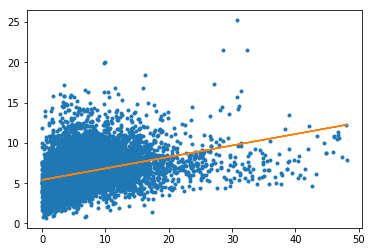

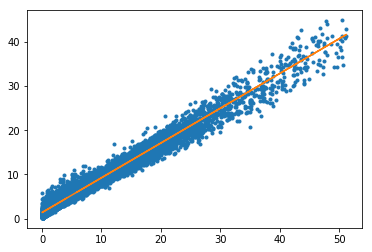

Score for Test set:  0.11129631731546753
Score for Train set:  0.9354210586712929


In [104]:
#RF with SPECIFIC libraries removed.
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 60)

X = DFforRF1.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = DFforRF1['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

In [107]:
#Does dividing by POPU_LSA help? It should...
#divide all columns except for hours by population
DFforRF1_POPDIV = copy.deepcopy(DFforRF1)

cols_to_divide_by_pop = ['BENEFIT','BKMOB','BKVOL','BRANLIB','CAPITAL',
 'CENTLIB','EBOOK','ELMATEXP','KIDPRO',
 'LIBRARIAN-LIBRARIA',
 'LOANFM',
 'LOANTO',
 'MASTER',
 'OTHMATEX',
 'OTHOPEXP',
 'OTHPAID',
 'PRMATEXP',
 'SALARIES',
 'STAFFEXP-TOTEXP',
 'TOTEXPCO-TOTEXPCOL',
 'TOTOPEXP-TOTOPEXP1',
 'TOTPRO',
 'TOTPEMP-TOTSTAFF',
 'YAPRO',
 'AUDIO',
 'VIDEO']


for col in cols_to_divide_by_pop:
    DFforRF1_POPDIV[col] = DFforRF1_POPDIV[col].astype(float)/DFforRF1_POPDIV['POPU-POPU_LSA']

                    importance
TOTOPEXP-TOTOPEXP1    0.379260
TOTPEMP-TOTSTAFF      0.106501
DUPLI-HRS_OPEN        0.039276
TOTPRO                0.037705
LOANFM                0.035571
BKVOL                 0.035378
VIDEO                 0.030212
KIDPRO                0.029023
AUDIO                 0.028374
PRMATEXP              0.026585
TOTEXPCO-TOTEXPCOL    0.022619
LIBRARIAN-LIBRARIA    0.022421
CENTLIB               0.022230
OTHPAID               0.020365
LOANTO                0.020028
OTHOPEXP              0.019814
OTHMATEX              0.019185
YAPRO                 0.017676
ELMATEXP              0.014080
BENEFIT               0.013451
SALARIES              0.012567
EBOOK                 0.011712
MASTER                0.011287
STAFFEXP-TOTEXP       0.010530
CAPITAL               0.007643
BRANLIB               0.004980
BKMOB                 0.001531


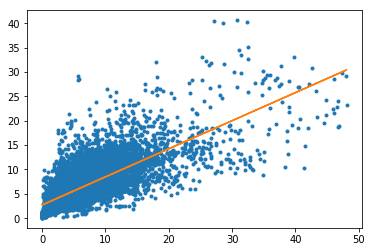

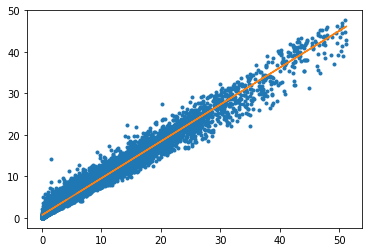

Score for Test set:  0.5595167904710593
Score for Train set:  0.9643731353962143


In [108]:
#RF with SPECIFIC libraries removed, and all values (except hours open) divided by PopuLSA!!.
#THIS WORKS MUCH MUCH BETTER
rfmodel = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 60)

X = DFforRF1_POPDIV.drop(columns = ['Usage', 'POPU-POPU_LSA'])
y = DFforRF1_POPDIV['Usage']

X_train = X.drop(X.index[flattened_Indexlist])
y_train = y.drop(y.index[flattened_Indexlist])
X_test = X.loc[flattened_Indexlist]
y_test = y.loc[flattened_Indexlist]

#Train model on TRAIN set
rfmodel.fit(X_train, y_train);

#Test model on TEST set (this is the right this to do)
predictions = rfmodel.predict(X_test)
errors = abs(predictions - y_test)
#df of predictions, labels and errors
df_TEST = pd.DataFrame()
df_TEST['Usage_val'] = y_test
df_TEST['Predictions'] = predictions
df_TEST['errors'] = (list(errors))

#Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
predictions = rfmodel.predict(X_train)
errors = abs(predictions - y_train)
#df of predictions, labels and errors
df_TRAIN = pd.DataFrame()
df_TRAIN['Usage_val'] = y_train
df_TRAIN['Predictions'] = predictions
df_TRAIN['errors'] = (list(errors))

#Get feature importance
feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

#Plot df_TEST Usage vs. Prediction:
# Data
x = df_TEST.iloc[:, 0]
y = df_TEST.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

#Plot df_TRAIN Usage vs. Prediction:
# Data
x = df_TRAIN.iloc[:, 0]
y = df_TRAIN.iloc[:, 1]
# Fit with polyfit
b, m = polyfit(x, y, 1)
plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-')
plt.show()

print("Score for Test set: ", rfmodel.score(X_test, y_test))
print("Score for Train set: ", rfmodel.score(X_train, y_train))

### RF above looks overfit:
1. I will not change number of trees (n_estimators) for now. In RF in Notebook 5, I saw no difference between 100 and 1000 trees (of course, the data there was processed very differently).
2. Try 0: Run as above for baseline
3. Try 1: Max features reduced to square root.
4. Try 2: Max depth reduced to 30 (from 60).
5. Try 3: Max features reduced to square root and depth reduced to 30 (from 60)

In [110]:
#before trying all these diff options, I will make RF function.
def rffunction(DF_for_RF, n_est_number, rstate, mdepth, max_feat_str):
    rfmodel = RandomForestRegressor(n_estimators = n_est_number, random_state = rstate, max_depth = mdepth, max_features = max_feat_str)

    X = DF_for_RF.drop(columns = ['Usage', 'POPU-POPU_LSA'])
    y = DF_for_RF['Usage']

    X_train = X.drop(X.index[flattened_Indexlist])
    y_train = y.drop(y.index[flattened_Indexlist])
    X_test = X.loc[flattened_Indexlist]
    y_test = y.loc[flattened_Indexlist]

    #Train model on TRAIN set
    rfmodel.fit(X_train, y_train);

    #Test model on TEST set (this is the right this to do)
    predictions = rfmodel.predict(X_test)
    errors = abs(predictions - y_test)
    #df of predictions, labels and errors
    df_TEST = pd.DataFrame()
    df_TEST['Usage_val'] = y_test
    df_TEST['Predictions'] = predictions
    df_TEST['errors'] = (list(errors))

    #Test model on TRAIN set (this is technically the wrong thing to do, but still informative)
    predictions = rfmodel.predict(X_train)
    errors = abs(predictions - y_train)
    #df of predictions, labels and errors
    df_TRAIN = pd.DataFrame()
    df_TRAIN['Usage_val'] = y_train
    df_TRAIN['Predictions'] = predictions
    df_TRAIN['errors'] = (list(errors))

    #Get feature importance
    feature_importances = pd.DataFrame(rfmodel.feature_importances_,
                                       index = X_train.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

    #Plot df_TEST Usage vs. Prediction:
    # Data
    x = df_TEST.iloc[:, 0]
    y = df_TEST.iloc[:, 1]
    # Fit with polyfit
    b, m = polyfit(x, y, 1)
    plt.plot(x, y, '.')
    plt.plot(x, b + m * x, '-')
    plt.show()

    #Plot df_TRAIN Usage vs. Prediction:
    # Data
    x = df_TRAIN.iloc[:, 0]
    y = df_TRAIN.iloc[:, 1]
    # Fit with polyfit
    b, m = polyfit(x, y, 1)
    plt.plot(x, y, '.')
    plt.plot(x, b + m * x, '-')
    plt.show()

    print("Score for Test set: ", rfmodel.score(X_test, y_test))
    print("Score for Train set: ", rfmodel.score(X_train, y_train))

In [ ]:
print("Same as RF above.")
rffunction(DF_for_RF = DFforRF1_POPDIV, n_est_number = 100, rstate = 42, mdepth = 60, max_feat_str = "auto")
print("Max features reduced to square root")
rffunction(DF_for_RF = DFforRF1_POPDIV, n_est_number = 100, rstate = 42, mdepth = 60, max_feat_str = "sqrt")
print("Max depth reduced to 30 (from 60)")
rffunction(DF_for_RF = DFforRF1_POPDIV, n_est_number = 100, rstate = 42, mdepth = 30, max_feat_str = "auto")
print("Max features reduced to square root and depth reduced to 30 (from 60)")
rffunction(DF_for_RF = DFforRF1_POPDIV, n_est_number = 100, rstate = 42, mdepth = 30, max_feat_str = "sqrt")



Same as RF above.
